In [1]:
import torch
from transformers import BertTokenizer, BertModel
import os, csv
from models import SNACSDataset

# MODELS
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased',
    output_hidden_states = True,
)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [2]:
import os, csv

data = []
sentences = []
current_sentence = []
length = 0

out_of_vocab = {'ड़': 'ड़', 'ढ़': 'ढ़', '‘': '', '‘': '', "'": '', '"': ''}

for entry in os.scandir('../annotations/lp_aryaman'):
    if entry.path.endswith('.csv'):
        
        with open(entry, 'r') as fin:
            reader = csv.reader(fin)
            for i, row in enumerate(reader):
                if i == 0: continue
                
                for i, j in out_of_vocab.items():
                    row[0] = row[0].replace(i, j)
                
                if row[0] == '':
                    if current_sentence:
                        sentences.append(current_sentence)
                        length = 0
                    current_sentence = []
                else:
                    if row[2]: data.append([row[0], row[2], row[3], len(sentences), length])
                    length += len(row[0])
                    current_sentence.append(row[0])

        if current_sentence:
            sentences.append(current_sentence)
            
# this is our training data
print(data[:10])
print(len(data))

[['मैंने', 'Experiencer', 'Agent', 2, 0], ['तेरा', 'Theme', 'Theme', 2, 5], ['उसकी', 'Gestalt', 'Gestalt', 2, 14], ['तक', 'Duration', 'EndTime', 3, 9], ['मेरे', 'Possessor', 'Possessor', 3, 11], ['का', 'Purpose', 'Purpose', 3, 26], ['का', 'Gestalt', 'Gestalt', 3, 51], ['इसका', 'Topic', 'Topic', 4, 0], ['मुझे', 'Recipient', 'Recipient', 4, 7], ['तुझसे', 'Agent', 'Ancillary', 4, 11]]
2450


In [3]:
# tokenize sentences
print(' '.join(sentences[0]))
sentences = [tokenizer.tokenize('[CLS] ' + ' '.join(sentence) + ' [SEP]') for sentence in sentences]

print(len(sentences))
print(sentences[:5])

ओह !
1722
[['[CLS]', 'ओ', '##ह', '!', '[SEP]'], ['[CLS]', 'न', '##न्', '##हे', '##ं', 'र', '##ाज', '##क', '##ु', '##मा', '##र', '!', '[SEP]'], ['[CLS]', 'म', '##ैं', '##ने', 'ते', '##रा', 'जीवन', ',', 'उसकी', 'उ', '##दा', '##सी', 'ध', '##ीर', '##े', '-', 'ध', '##ीर', '##े', 'स', '##म', '##झ', 'ली', 'थी', '[SEP]'], ['[CLS]', 'बहुत', 'दिन', '##ों', 'तक', 'मे', '##रे', 'पास', 'म', '##न', 'ब', '##ह', '##ला', '##ने', 'का', 'एक', 'मात्रा', 'स', '##ा', '##धन', 'था', 'स', '##ूर', '##्यास', '##्त', 'का', 'स', '##ौ', '##ंदर', '##्य', '।', '[SEP]'], ['[CLS]', 'इसका', 'पता', 'म', '##ु', '##झ', '##े', 'त', '##ु', '##झ', '##से', 'म', '##ुल', '##ा', '##का', '##त', 'के', 'च', '##ौ', '##थे', 'दिन', 'च', '##ला', 'जब', 'त', '##ून', '##े', 'म', '##ु', '##झ', '##से', 'कहा', ':', '[SEP]']]


In [4]:
# Map the token strings to their vocabulary indeces.
indexed_tokens = [tokenizer.convert_tokens_to_ids(sentence) for sentence in sentences]
print(indexed_tokens[0])
print(sentences[0])


[101, 863, 17110, 106, 102]
['[CLS]', 'ओ', '##ह', '!', '[SEP]']


In [5]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-multilingual-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [6]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
outputs = []
with torch.no_grad():
    
    for i, sentence in enumerate(indexed_tokens):
        if len(sentence) == 0:
            outputs.append([])
            continue
        # Mark each of the 22 tokens as belonging to sentence "1".
        segments_ids = [1] * len(sentence)
        if i % 10 == 0: print(i)
        
        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([sentence])
        segments_tensors = torch.tensor([segments_ids])
        
        outputs.append(model(tokens_tensor, segments_tensors))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720


In [7]:
outputs[0]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3722, -0.2836,  0.2937,  ...,  0.6907,  0.2142,  0.2329],
         [ 0.3534, -0.5321,  0.2235,  ...,  1.0148,  0.1673,  0.2986],
         [ 0.6164, -0.2585,  0.7959,  ...,  0.7183, -0.1231, -0.1010],
         [ 0.3348, -0.2729,  0.5100,  ...,  0.6602,  0.1632,  0.2698],
         [ 0.4161, -0.2375,  0.4754,  ...,  0.4744,  0.0905,  0.2347]]]), pooler_output=tensor([[ 3.3972e-01,  2.4252e-01,  8.5810e-02,  6.2661e-02, -1.4015e-01,
          1.4702e-01,  7.4292e-02, -2.9657e-02,  6.9910e-02,  1.9596e-01,
         -1.1321e-03, -1.0474e-01, -3.1804e-01, -1.2298e-01,  1.4344e-01,
          9.6834e-02,  3.1660e-02,  1.9304e-02, -1.1957e-01, -1.4818e-01,
         -9.7831e-01, -5.8960e-02,  1.7460e-01, -2.0389e-01, -1.4001e-01,
         -2.4887e-01, -1.1476e-01, -1.5955e-01,  2.1249e-01, -1.5593e-01,
         -1.2544e-01, -9.8624e-01,  3.2594e-01,  4.3030e-01,  3.9739e-01,
         -7.1544e-02,  5.5542e-02,  2.3614e-01,

In [8]:
all_embeddings = []
for i, output in enumerate(outputs):
    if i % 100 == 0: print(i)
    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(output[2], dim=0)
    
    # Remove dimension 1, the "batches".
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    
    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,0,2)
    all_embeddings.append(token_embeddings)

print(len(sentences), len(all_embeddings))
for i in range(len(sentences)):
    if len(sentences[i]) != len(all_embeddings[i]):
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1722 1722


In [9]:
cur_word_length = 0
concatenated_embeddings = []
for i, token_embeddings in enumerate(all_embeddings):
    # Stores the token vectors, with shape [22 x 3,072]
    token_vecs_cat = {}
    if i % 100 == 0: print(i)

    # `token_embeddings` is a [22 x 12 x 768] tensor.
    # print(token_embeddings.size())

    # For each token in the sentence...
    length = 0
    for j, token in enumerate(token_embeddings):

        # `token` is a [12 x 768] tensor

        # Concatenate the vectors (that is, append them together) from the last 
        # four layers.
        # Each layer vector is 768 values, so `cat_vec` is length 3,072.
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        
        # Sum the vectors from the last four layers.
        # sum_vec = torch.sum(token[-4:], dim=0)

        # Use `cat_vec` to represent `token`.
        if j == 0:
            token_vecs_cat[length] = [cat_vec, sentences[i][j]]
        elif sentences[i][j].startswith('##'):
            length += len(sentences[i][j]) - 2
        else:
            token_vecs_cat[length] = [cat_vec, sentences[i][j]]
            length += len(sentences[i][j])
    
    concatenated_embeddings.append(token_vecs_cat)

#     print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [11]:
torch.save(concatenated_embeddings, 'embeddings.pickle')

In [6]:
concatenated_embeddings = torch.load('embeddings.pickle')

In [7]:
for _, i in enumerate(data):
    if i[4] not in concatenated_embeddings[i[3]]:
        print(sentences[i[3]])
        print([i for i in concatenated_embeddings[i[3]]])
        print(i)

['[CLS]', 'म', '##ैं', 'ते', '##री', 'भ', '##ेड', '##़', 'का', 'म', '##ु', '##ं', '##ह', 'ब', '##ंद', 'करने', 'के', 'लिए', 'एक', 'जा', '##बा', 'बना', 'द', '##ू', '##ंगा', ',', 'ते', '##रे', 'फ', '##ूल', 'के', 'लिए', 'क', '##व', '##च', 'बना', 'द', '##ू', '##ंगा', '।', '[SEP]']
[0, 3, 7, 11, 13, 17, 20, 24, 26, 29, 31, 35, 40, 43, 48, 49, 53, 56, 58, 61, 64, 67, 72, 73]
['तेरे', 'Possessor', 'Possessor', 96, 44]
['[CLS]', 'म', '##ैं', 'ते', '##री', 'भ', '##ेड', '##़', 'का', 'म', '##ु', '##ं', '##ह', 'ब', '##ंद', 'करने', 'के', 'लिए', 'एक', 'जा', '##बा', 'बना', 'द', '##ू', '##ंगा', ',', 'ते', '##रे', 'फ', '##ूल', 'के', 'लिए', 'क', '##व', '##च', 'बना', 'द', '##ू', '##ंगा', '।', '[SEP]']
[0, 3, 7, 11, 13, 17, 20, 24, 26, 29, 31, 35, 40, 43, 48, 49, 53, 56, 58, 61, 64, 67, 72, 73]
['के', 'Beneficiary', 'Beneficiary', 96, 51]
['[CLS]', 'इसी', 'तरह', 'र', '##ाज', '##क', '##ु', '##मा', '##र', 'से', 'म', '##ुल', '##ा', '##का', '##त', 'के', 'ती', '##सर', '##े', 'दिन', 'म', '##ु', '##झ', '##े', 'ब'

In [8]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
same_bank = 1 - cosine(concatenated_embeddings[14][6][0], concatenated_embeddings[14][11][0])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
diff_bank = 1 - cosine(concatenated_embeddings[14][6][0], concatenated_embeddings[14][3][0])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

diff_bank = 1 - cosine(concatenated_embeddings[4][11][0], concatenated_embeddings[10][1][0])
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

KeyError: 3

In [9]:
print(len(data), len(concatenated_embeddings))
print(data[0])
for i in data:
    print(sentences[i[3]], i)
    if len(concatenated_embeddings[i[3]][i[4]]) != 2:
        print(i)

2450 1722
['मैंने', 'Experiencer', 'Agent', 2, 0]
['[CLS]', 'म', '##ैं', '##ने', 'ते', '##रा', 'जीवन', ',', 'उसकी', 'उ', '##दा', '##सी', 'ध', '##ीर', '##े', '-', 'ध', '##ीर', '##े', 'स', '##म', '##झ', 'ली', 'थी', '[SEP]'] ['मैंने', 'Experiencer', 'Agent', 2, 0]
['[CLS]', 'म', '##ैं', '##ने', 'ते', '##रा', 'जीवन', ',', 'उसकी', 'उ', '##दा', '##सी', 'ध', '##ीर', '##े', '-', 'ध', '##ीर', '##े', 'स', '##म', '##झ', 'ली', 'थी', '[SEP]'] ['तेरा', 'Theme', 'Theme', 2, 5]
['[CLS]', 'म', '##ैं', '##ने', 'ते', '##रा', 'जीवन', ',', 'उसकी', 'उ', '##दा', '##सी', 'ध', '##ीर', '##े', '-', 'ध', '##ीर', '##े', 'स', '##म', '##झ', 'ली', 'थी', '[SEP]'] ['उसकी', 'Gestalt', 'Gestalt', 2, 14]
['[CLS]', 'बहुत', 'दिन', '##ों', 'तक', 'मे', '##रे', 'पास', 'म', '##न', 'ब', '##ह', '##ला', '##ने', 'का', 'एक', 'मात्रा', 'स', '##ा', '##धन', 'था', 'स', '##ूर', '##्यास', '##्त', 'का', 'स', '##ौ', '##ंदर', '##्य', '।', '[SEP]'] ['तक', 'Duration', 'EndTime', 3, 9]
['[CLS]', 'बहुत', 'दिन', '##ों', 'तक', 'मे', '##रे', 'पास',

KeyError: 44

In [43]:
import importlib
import models
importlib.reload(models)

<module 'models' from '/Users/aryamanarora/Documents/computerscience/CARMLS/prediction/models.py'>

In [44]:
real_data = models.SNACSDataset(data, concatenated_embeddings)

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
components = pca.fit_transform(real_data.df.loc[:,:'e3071'])
print(components[0])

[ 2.40436467e+01 -7.76951992e+00 -6.68051757e+00 ...  1.23863055e-18
 -3.55762774e-19  2.17371899e-19]


In [89]:
print(real_data.df.loc[0])

e0             0.328664
e1            -0.181971
e2              1.37394
e3             0.298746
e4             0.021552
               ...     
e3070          0.814385
e3071        -0.0695136
scene       Experiencer
function          Agent
name              मैंने
Name: 0, Length: 3075, dtype: object


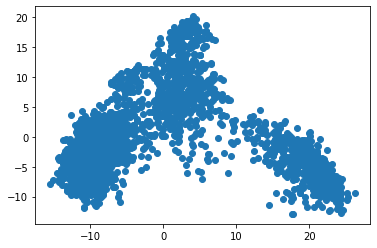

In [63]:
plt.scatter(components[:,0], components[:,1])
plt.show()

In [1]:
for i in ['मुझे', 'को', 'तुझको', 'उसको', 'तुमको']:
    plt.scatter(components[real_data.df['name']==i][:,0], components[real_data.df['name']==i][:,1])
plt.show()

NameError: name 'plt' is not defined